<a href="https://colab.research.google.com/github/dadulrishan/cv/blob/main/final_dissertation_(80_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras.backend as K

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dadulrishan","key":"779b6b4722ecb849b78e947efdbe85c2"}'}

In [ ]:
# Make the .kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100% 60.3M/60.3M [00:02<00:00, 43.3MB/s]
100% 60.3M/60.3M [00:02<00:00, 30.6MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
!ls

fer2013.zip  sample_data  test	train


In [ ]:
# Verify dataset paths

import os
def check_dataset_paths(train_dir, test_dir):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory {train_dir} not found.")
    if not os.path.exists(test_dir):
        raise FileNotFoundError(f"Test directory {test_dir} not found.")
    print("Dataset paths verified. Training and test directories exist.")

TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

check_dataset_paths(TRAIN_DIR, TEST_DIR)

Dataset paths verified. Training and test directories exist.


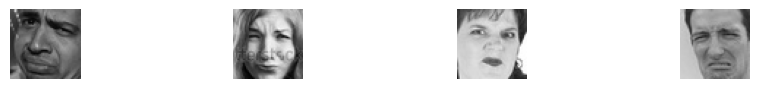

In [ ]:
#Preview Images from Dataset
import random
import os
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

def preview_images(data_dir, num_images=4):
    cls = random.choice(os.listdir(data_dir))
    cls_path = os.path.join(data_dir, cls)
    image_names = random.sample(os.listdir(cls_path), min(num_images, len(os.listdir(cls_path))))

    fig, axes = plt.subplots(1, num_images, figsize=(10, 1))
    for ax, img_name in zip(axes, image_names):
        img_path = os.path.join(cls_path, img_name)
        ax.imshow(load_img(img_path))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

preview_images(TRAIN_DIR)

<ipython-input-9-2c542275cc3a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts, palette="viridis")


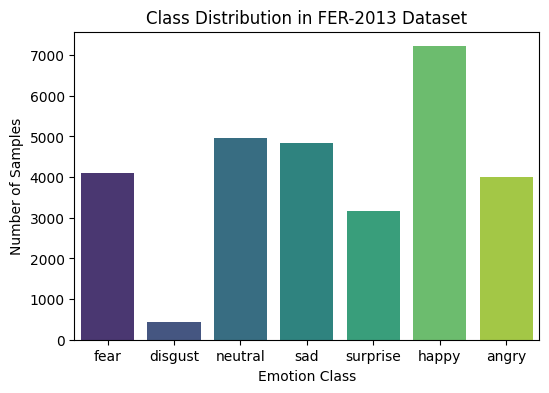

In [ ]:
#Bar Plot of Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt
import os

TRAIN_DIR = '/content/train'
class_labels = os.listdir(TRAIN_DIR)
class_counts = [len(os.listdir(os.path.join(TRAIN_DIR, label))) for label in class_labels]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_labels, y=class_counts, palette="viridis")
plt.title('Class Distribution in FER-2013 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
#Create Data Generators
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, valid_datagen, test_datagen

train_datagen, valid_datagen, test_datagen = create_data_generators()

In [ ]:
import os

# Function to check if directories exist
def verify_directories(*dirs):
    for dir_path in dirs:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        print(f"Directory exists: {dir_path}")

# Directories to verify
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

# Verify directories
verify_directories(TRAIN_DIR, TEST_DIR)

# Creating Data Sets
train_dataset = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)


Directory exists: /content/train
Directory exists: /content/test
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


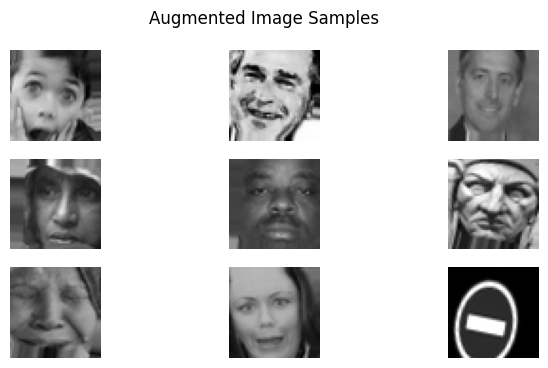

In [ ]:
# Display augmented images
augmented_images, _ = next(train_dataset)  # Get a batch of augmented images
plt.figure(figsize=(8, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Augmented Image Samples')
plt.show()

In [ ]:
def dataset_statistics(dataset):
    class_counts = dataset.classes
    class_labels = list(dataset.class_indices.keys())
    total_images = len(class_counts)
    class_distribution = pd.Series(class_counts).value_counts()

    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for label, count in zip(class_labels, class_distribution):
        print(f"{label}: {count}")

# Display statistics
dataset_statistics(train_dataset)

Total Images: 22968
Class Distribution:
angry: 5772
disgust: 3972
fear: 3864
happy: 3278
neutral: 3196
sad: 2537
surprise: 349


Training Batch Preview:


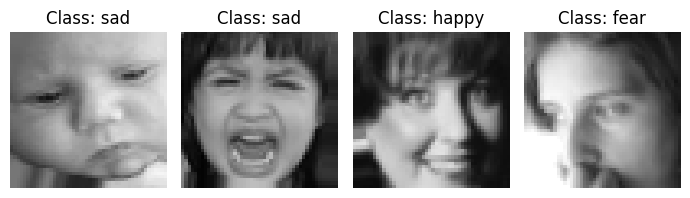

Validation Batch Preview:


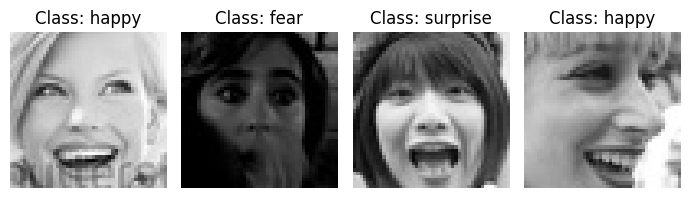

In [ ]:
def preview_batch(dataset, num_images=4):
    images, labels = next(dataset)
    class_indices = {v: k for k, v in dataset.class_indices.items()}  # Reverse class mapping
    fig, axes = plt.subplots(1, num_images, figsize=(7, 5))
    for img, lbl, ax in zip(images[:num_images], labels[:num_images], axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class: {class_indices[np.argmax(lbl)]}")
    plt.tight_layout()
    plt.show()

# Preview batches
print("Training Batch Preview:")
preview_batch(train_dataset)

print("Validation Batch Preview:")
preview_batch(valid_dataset)


Class Distribution imbalance:


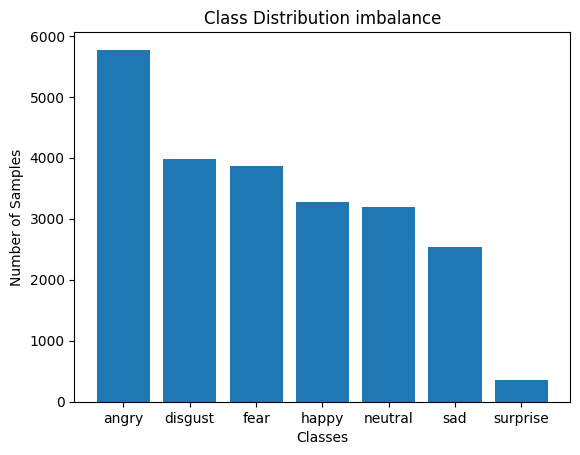

In [ ]:
def check_class_imbalance(dataset):
    class_counts = pd.Series(dataset.classes).value_counts()
    class_labels = list(dataset.class_indices.keys())
    plt.bar(class_labels, class_counts)
    plt.title("Class Distribution imbalance")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.show()

# Check for class imbalance
print("Class Distribution imbalance:")
check_class_imbalance(train_dataset)

In [ ]:
def save_metadata(dataset, filename):
    metadata = {
        "class_indices": dataset.class_indices,
        "num_classes": len(dataset.class_indices),
        "total_images": len(dataset.classes)
    }
    with open(filename, "w") as f:
        f.write(str(metadata))
    print(f"Metadata saved to {filename}")

# Save metadata
save_metadata(train_dataset, "train_metadata.txt")
save_metadata(valid_dataset, "valid_metadata.txt")
save_metadata(test_dataset, "test_metadata.txt")

Metadata saved to train_metadata.txt
Metadata saved to valid_metadata.txt
Metadata saved to test_metadata.txt


In [ ]:
from tensorflow.keras.regularizers import l2
# Model Definition
def build_model():
    base_model = VGG16(input_shape=(48, 48, 3), include_top=False, weights="imagenet")

    # Freeze all layers except the last 4
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
    base_model,
    Flatten(),
    Dense(256, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),  # Adjusted L2 strength
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),  # Increased dropout to mitigate overfitting
    Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),
    Dense(7, activation='softmax')  # Final layer for 7 emotion categories
])

    return model

model = build_model()

# Model Summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,881,351 (56.77 MB)

 Trainable params: 7,245,319 (27.64 MB)

 Non-trainable params: 7,636,032 (29.13 MB)

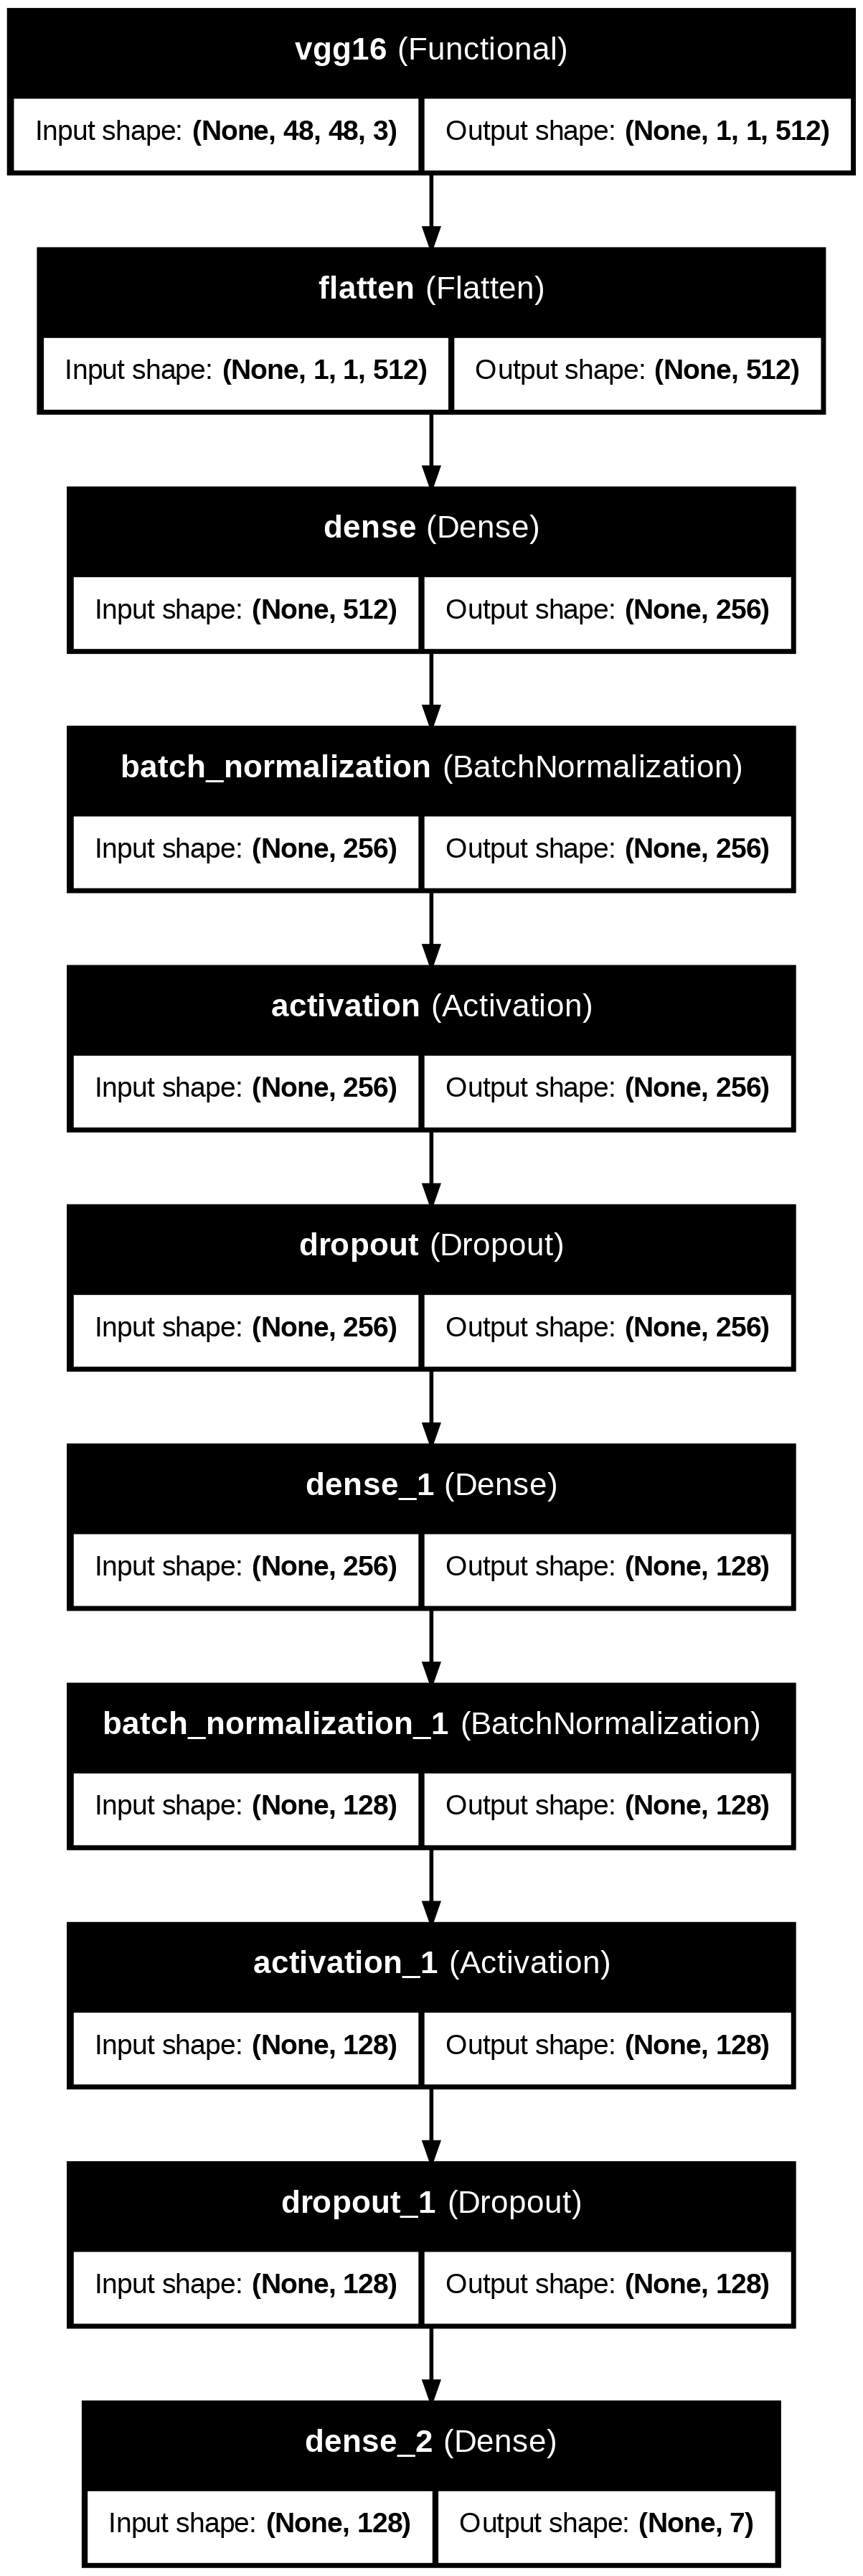

In [ ]:
from tensorflow.keras.utils import plot_model

# Save and display the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
import tensorflow.keras.backend as K  # Import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score
]

# Compile with Categorical Crossentropy Loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=METRICS
)



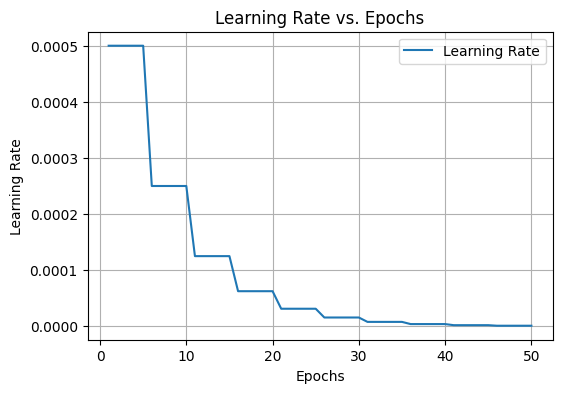

In [ ]:
# Extract learning rate history from the ReduceLROnPlateau callback
lrs = [0.0005 * (0.5 ** (i // 5)) for i in range(50)]  # Example if patience is 5

# Plot learning rate changes
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(lrs) + 1), lrs, label='Learning Rate')
plt.title('Learning Rate vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid()
plt.legend()
plt.show()


In [ ]:
lrd = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
mcp = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,  # Increased epochs if necessary
    callbacks=[lrd, es, mcp],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 133ms/step - accuracy: 0.1772 - auc: 0.5429 - f1_score: 0.1005 - loss: 3.2566 - precision: 0.1998 - recall: 0.0677 - val_accuracy: 0.3564 - val_auc: 0.7391 - val_f1_score: 0.2660 - val_loss: 2.3551 - val_precision: 0.5948 - val_recall: 0.1726 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.3074 - auc: 0.6904 - f1_score: 0.2225 - loss: 2.6295 - precision: 0.4131 - recall: 0.1532 - val_accuracy: 0.4410 - val_auc: 0.8056 - val_f1_score: 0.3401 - val_loss: 2.1169 - val_precision: 0.6309 - val_recall: 0.2338 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.3566 - auc: 0.7378 - f1_score: 0.2643 - loss: 2.3806 - precision: 0.4970 - recall: 0.1804 - val_accuracy: 0.4379 - val_auc: 0.8035 - val_f1_score: 0.3887 - val_loss: 2.1249 - val_precision: 0.5799 - val_recall: 0.2940 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy:

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_dataset, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {test_f1}")


113/113 - 4s - 38ms/step - accuracy: 0.5823 - auc: 0.8860 - f1_score: 0.5605 - loss: 1.3100 - precision: 0.6787 - recall: 0.4811
Test Loss: 1.3100172281265259
Test Accuracy: 0.5823349356651306
Test Precision: 0.6786556839942932
Test Recall: 0.4810532033443451
Test AUC: 0.8859957456588745
Test F1 Score: 0.560531497001648


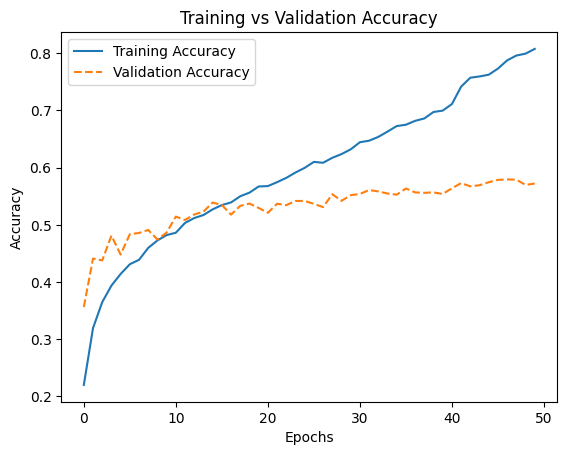

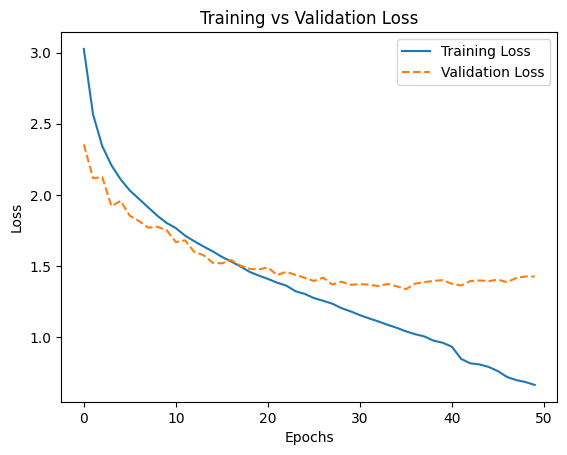

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


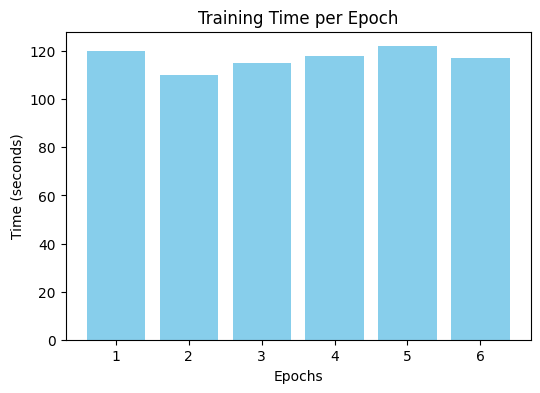

In [ ]:
# Example of plotting epoch times
epoch_times = [120, 110, 115, 118, 122, 117]  # Replace with actual timing data for each epoch
epochs = range(1, len(epoch_times) + 1)

plt.figure(figsize=(6, 4))
plt.bar(epochs, epoch_times, color="skyblue")
plt.title('Training Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.show()


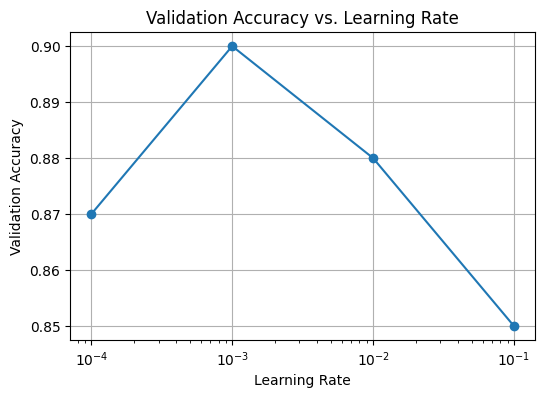

In [ ]:
# Example validation accuracies for different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
val_accuracies = [0.85, 0.88, 0.90, 0.87]

plt.figure(figsize=(6, 4))
plt.plot(learning_rates, val_accuracies, marker='o')
plt.xscale('log')  # Logarithmic scale for learning rates
plt.title('Validation Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.show()


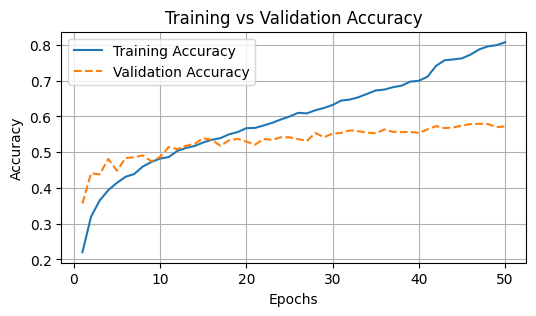

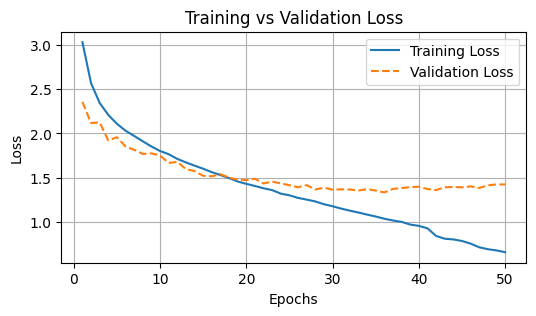

In [ ]:
# Assuming 'history' is the output of model.fit()
epochs = range(1, len(history.history['accuracy']) + 1)

# Extract metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 3))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(6, 3))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


225/225 - 5s - 22ms/step - accuracy: 0.5823 - auc: 0.8860 - f1_score: 0.5613 - loss: 1.3100 - precision: 0.6787 - recall: 0.4811
Test Loss: 1.3100169897079468
Test Accuracy: 0.5823349356651306
Test Precision: 0.6786556839942932
Test Recall: 0.4810532033443451
Test AUC: 0.8859957456588745
Test F1 Score: 0.5613491535186768
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.54      0.50       958
           1       0.44      0.58      0.50       111
           2       0.55      0.29      0.38      1024
           3       0.74      0.79      0.76      1774
           4       0.48      0.66      0.56      1233
           5       0.50      0.39      0.44      1247
           6       0.72      0.74      0.73       831

    accuracy                           0.58      7178
   macro avg       0.56      0.57      0.55      7178
weighted avg       0.58      0.58      0.57      7178



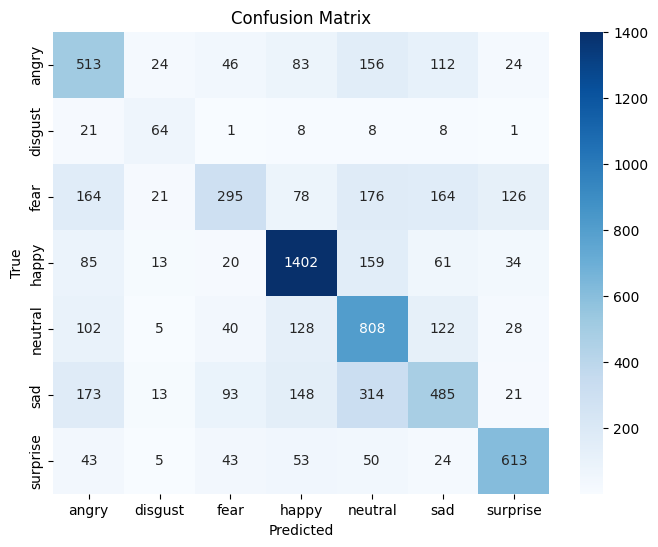

Test ROC-AUC: 0.87


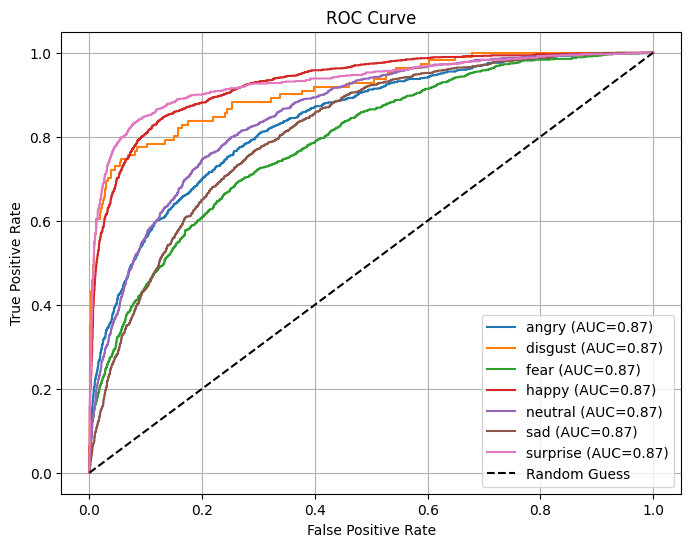

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Extract X_test and y_test from the test_dataset
X_test, y_test = [], []
for i in range(len(test_dataset)):
    images, labels = test_dataset[i]
    X_test.extend(images)
    y_test.extend(labels)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1 Score: {test_f1}")

# Generate predictions
y_pred_probs = model.predict(X_test)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices
y_true = np.argmax(y_test, axis=1)  # True class indices

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score and Curve
auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")
print(f"Test ROC-AUC: {auc:.2f}")
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(test_dataset.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()


718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


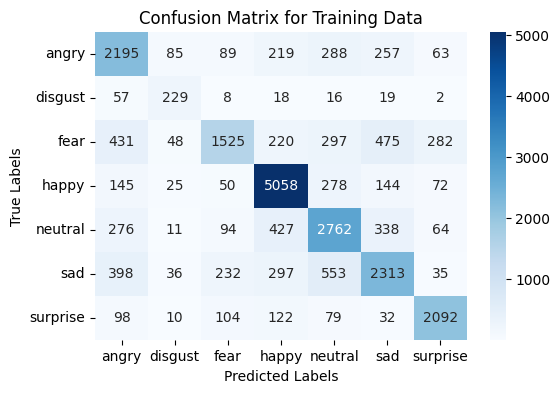

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on training data
X_train, y_train = [], []
for i in range(len(train_dataset)):
    images, labels = train_dataset[i]
    X_train.extend(images)
    y_train.extend(labels)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Generate predictions
y_train_pred_probs = model.predict(X_train)  # Get probabilities for each class
y_train_pred = np.argmax(y_train_pred_probs, axis=1)  # Get predicted class indices
y_train_true = np.argmax(y_train, axis=1)  # Get true class indices

# Step 2: Generate Confusion Matrix
conf_matrix = confusion_matrix(y_train_true, y_train_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.class_indices.keys(),
            yticklabels=train_dataset.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Training Data")
plt.show()


In [ ]:
# Save the model in .h5 format
model.save('emotion_recognition_model.h5')
print("Model saved as emotion_recognition_model.h5")



Model saved as emotion_recognition_model.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('emotion_recognition_model.h5')
print("Model successfully loaded.")


metrics = loaded_model.evaluate(valid_dataset, verbose=2)

# Unpack the metrics list into separate variables
val_loss = metrics[0]  # Loss is typically the first element
val_accuracy = metrics[1]  # Accuracy is typically the second element
# ... (unpack other metrics if needed)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")



Model successfully loaded.
90/90 - 5s - 59ms/step - accuracy: 0.5635 - auc: 0.8818 - f1_score: 0.5368 - loss: 1.3359 - precision: 0.6607 - recall: 0.4656
Validation Loss: 1.3358724117279053
Validation Accuracy: 0.5634906888008118


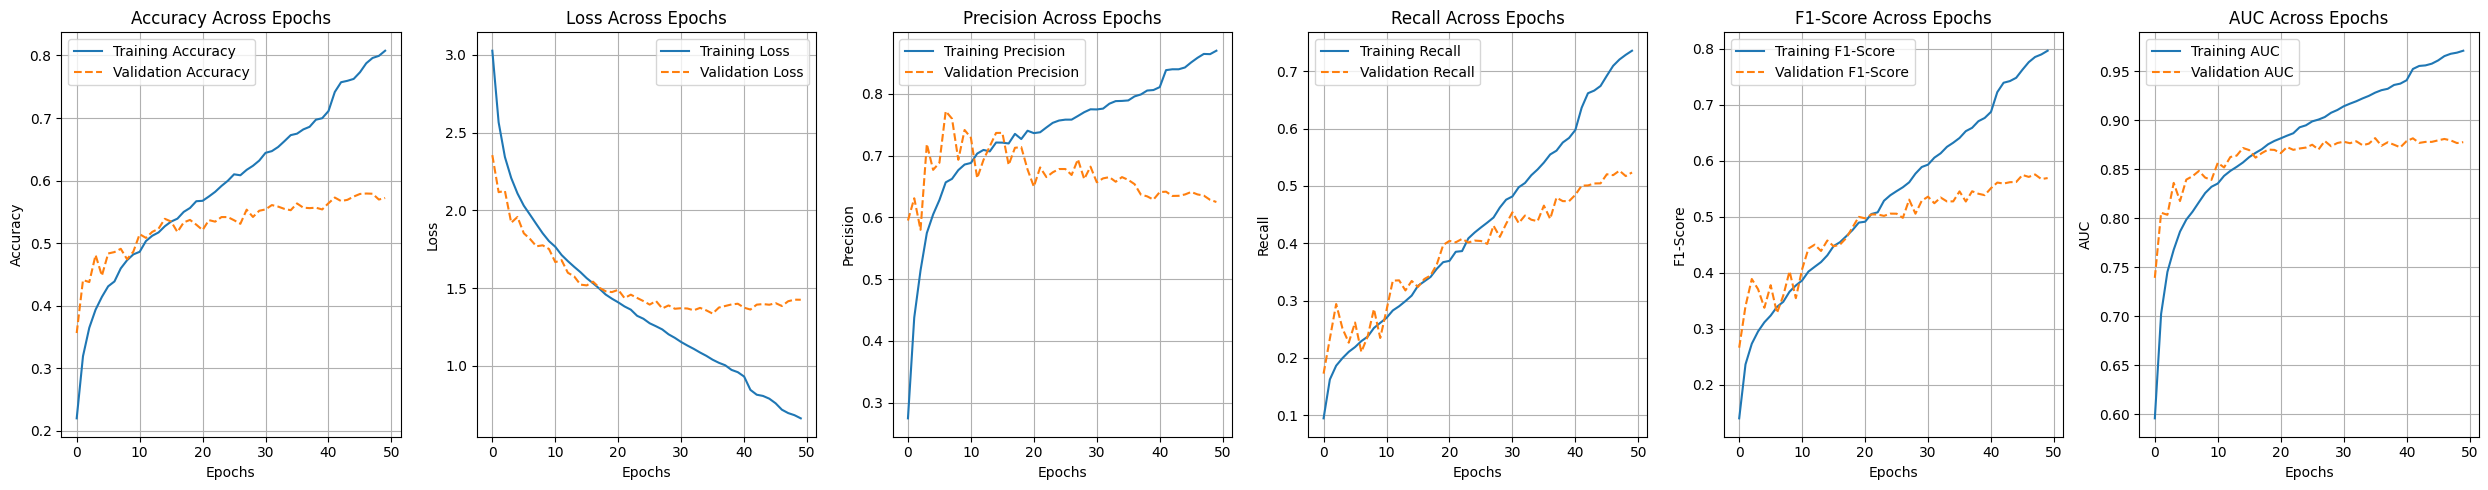

In [ ]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC']
y_labels = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Create subplots in a single row
fig, axes = plt.subplots(1, len(metrics), figsize=(25, 5))

for i, metric in enumerate(metrics):
    axes[i].plot(history.history[metric], label=f'Training {titles[i]}')
    axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}', linestyle='--')
    axes[i].set_title(f'{titles[i]} Across Epochs')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(y_labels[i])
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


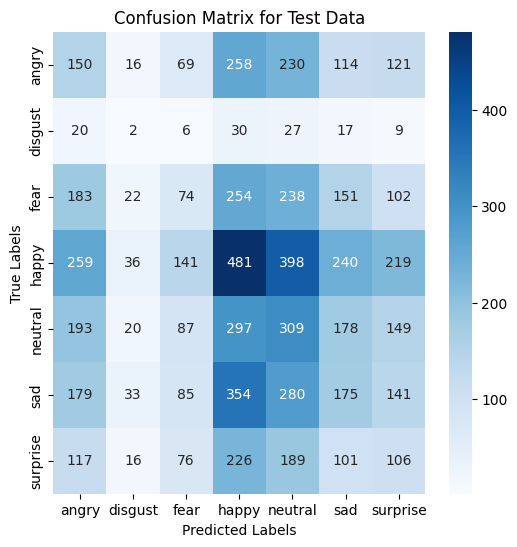

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data in batches
y_test_pred_probs = model.predict(test_dataset, verbose=1)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Use test_dataset.classes for true labels if available
y_test_true = test_dataset.classes

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Test Data")
plt.show()


Saving Screenshot 2024-12-26 152759.png to Screenshot 2024-12-26 152759 (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


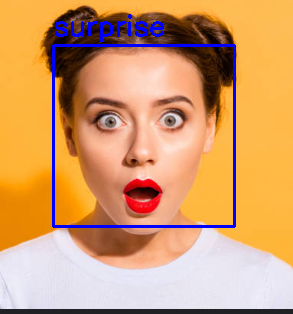

In [58]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from google.colab import files

# Load the trained model
# Changed the file name to match the saved model name
model = load_model('emotion_recognition_model.h5')

# Emotion labels (based on the dataset)
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to process and predict emotions
def predict_emotions(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray_frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face region
        face = gray_frame[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))  # Resize to model input size

        # Convert grayscale face to RGB
        face = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels
        face = face / 255.0  # Normalize pixel values
        face = np.reshape(face, (1, 48, 48, 3))  # Add batch dimension

        # Predict emotion
        predictions = model.predict(face)
        emotion = labels[np.argmax(predictions)]

        # Draw a rectangle around the face and label it
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(image, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the image with predictions
    cv2_imshow(image)

# Upload image
uploaded = files.upload()
image_path = next(iter(uploaded.keys()))  # Get the uploaded file name

# Predict and display emotions
predict_emotions(image_path)